# Gaussian Naive Bayes Classifier

The aim of this project is to implement and test a Guassian Naive Bayes classifier.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
import timeit

%matplotlib inline

## GaussianNB Classifier
An implementation of a Gaussian Naive Bayes that fits the framework.

In [2]:
class MyGaussianNB(BaseEstimator, ClassifierMixin):
    def fit(self, xt, yt):
        xt = np.array(xt)
        yt = np.array(yt)

        # first phase: compute class priors
        self._classes, self._class_priors = np.unique(yt, return_counts=True)
        self._class_priors = self._class_priors / float(np.sum(self._class_priors))  

        # second phase: compute all features' means and variances
        xt_split = [xt[yt==cl] for cl in self._classes]
        self._means = np.array([np.mean(xtcl, axis=0) for xtcl in xt_split])
        self._vars = np.array([np.var(xtcl, axis=0) for xtcl in xt_split])
        return self

    def predict(self, xtests):
        xtests = np.array(xtests)

        probas = self._compute_probas(xtests)
        return np.array([self._classes[i] for i in np.argmax(probas, axis=0)])

    def _compute_probas(self, xtests):
        return np.array([
            [
                self._class_priors[i] * np.product(self._conditional_proba(xtest, self._means[i], self._vars[i])) 
                for xtest in xtests
            ]
            for i in range(np.size(self._classes))
        ])
    
    @staticmethod
    def _conditional_proba(xt, m, var):
        return np.exp(-np.power(xt-m, 2)/(2*var))/np.sqrt(2*np.pi*var)

## Scikit vs My Gaussian Naives Bayes : Binary Classification
This function below will compare Scikit's Gaussian NB and mine in terms of performance.

In [3]:
def test_gaussian_on_dataset(x_train, y_train, x_test, y_test):
    scorings = ['accuracy', 'f1', 'precision', 'recall']


    X = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Not Helpful', 'Helpful'])
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title("Scikit GNB Confusion Matrix")
    disp.plot(ax=ax)

    print(f"Scikit GNB - Report:\n{report}")

    data = []
    for scoring in scorings:
        data.append({key: score.mean() for (key, score) in cross_validate(gnb, X, y, scoring=scoring).items()})
    print()
    print('CV x5 Scikit GNB: ')
    print(pd.DataFrame(data=data, columns=['test_score', 'fit_time', 'score_time'], index=scorings))
    print()
    
    mgnb = MyGaussianNB()
    mgnb.fit(x_train,y_train)
    y_pred = mgnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Not Helpful', 'Helpful'])
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title("My GNB Confusion Matrix")
    disp.plot(ax=ax)

    print(f"My GNB - Report:\n{report}")
    
    results = []
    for scoring in ['accuracy', 'f1', 'precision', 'recall']:
        results.append({key: score.mean() for (key, score) in cross_validate(mgnb, X, y, scoring=scoring).items()})
    print()
    print('CV x5 My GNB: ')
    print(pd.DataFrame(data=results, columns=['test_score', 'fit_time', 'score_time'], index=scorings))
    print()


This function below will compare Scikit's Gaussian NB and mine in terms of speed.

In [4]:
def test_speed_on_dataset(x_train, y_train, x_test, y_test, repeat=100):
    gnb = GaussianNB()
    gnb_fit_time = timeit.timeit(lambda: gnb.fit(x_train, y_train), number=repeat)
    gnb_predict_time = timeit.timeit(lambda: gnb.predict(x_test), number=repeat)
    
    print(f'Scikit GNB fit performance: {gnb_fit_time}s ({repeat} times)')
    print(f'Scikit GNB predict performance: {gnb_predict_time}s ({repeat} times)')

    mgnb = MyGaussianNB()
    mgnb_fit_time = timeit.timeit(lambda: mgnb.fit(x_train, y_train), number=repeat)
    mgnb_predict_time = timeit.timeit(lambda: mgnb.predict(x_test), number=repeat)

    print(f'My GNB fit performance: {mgnb_fit_time}s ({repeat} times)')
    print(f'My GNB predict performance: {mgnb_predict_time}s ({repeat} times)')

### Penguins dataset
Running and testing Gaussian Naive Bayes on the penguin dataset.

In [5]:
penguins_af = pd.read_csv('penguins_af.csv', index_col = 0)
print(penguins_af.shape)
penguins_af.head()

(333, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [6]:
penguins_af['target'] = np.where(penguins_af['species'] == 'Adelie', 1, 0)
f_names = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g', 'species', 'target']
penguins = penguins_af[f_names]
penguins2C = penguins.loc[penguins['species'].isin(['Adelie','Chinstrap'])]
penguins2C.pop('species')
penguins2C.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,target
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,1
2,40.3,18.0,195.0,3250.0,1
4,36.7,19.3,193.0,3450.0,1
5,39.3,20.6,190.0,3650.0,1


In [7]:
y = penguins2C.pop('target').values
X_raw = penguins2C.values
feature_names = penguins2C.columns
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
X_train.shape, X_test.shape

((107, 4), (107, 4))

Scikit GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.95      0.95      0.95        38
     Helpful       0.97      0.97      0.97        69

    accuracy                           0.96       107
   macro avg       0.96      0.96      0.96       107
weighted avg       0.96      0.96      0.96       107


CV x5 Scikit GNB: 
           test_score  fit_time  score_time
accuracy     0.953156  0.001437    0.000995
f1           0.965620  0.001398    0.001746
precision    0.966356  0.001824    0.002401
recall       0.966437  0.001848    0.001401

My GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.95      0.95      0.95        38
     Helpful       0.97      0.97      0.97        69

    accuracy                           0.96       107
   macro avg       0.96      0.96      0.96       107
weighted avg       0.96      0.96      0.96       107


CV x5 My GNB: 
           test_score  fit_time  score_time
accurac

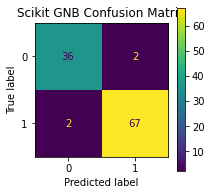

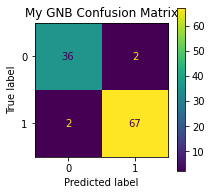

In [8]:
test_gaussian_on_dataset(X_train, y_train, X_test, y_test)

In [9]:
test_speed_on_dataset(X_train, y_train, X_test, y_test)

Scikit GNB fit performance: 0.07100049999999669s (100 times)
Scikit GNB predict performance: 0.015237400000003731s (100 times)
My GNB fit performance: 0.023719399999997393s (100 times)
My GNB predict performance: 0.3881833999999955s (100 times)


### Diabetes dataset
Running and testing Gaussian Naive Bayes on the diabetes test dataset.

In [10]:
diabetes = pd.read_csv('diabetes.csv', index_col = 0)
print(diabetes.shape)
diabetes.head()

(768, 8)


,plas,pres,skin,insu,mass,pedi,age,neg_pos
preg,,,,,,,,
6,148,72,35,0,33.6,0.627,50,tested_positive
1,85,66,29,0,26.6,0.351,31,tested_negative
8,183,64,0,0,23.3,0.672,32,tested_positive
1,89,66,23,94,28.1,0.167,21,tested_negative
0,137,40,35,168,43.1,2.288,33,tested_positive


In [11]:
diabetes['target'] = np.where(diabetes['neg_pos'] == 'tested_positive', 1, 0)
diabetes.pop('neg_pos').values
diabetes.head()

,plas,pres,skin,insu,mass,pedi,age,target
preg,,,,,,,,
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


In [12]:
y = diabetes.pop('target').values
Xorig = diabetes.values
scaler = StandardScaler()
X = scaler.fit_transform(Xorig)
X.shape, y.shape

((768, 7), (768,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

Scikit GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.79      0.88      0.83       174
     Helpful       0.67      0.51      0.58        82

    accuracy                           0.76       256
   macro avg       0.73      0.70      0.71       256
weighted avg       0.75      0.76      0.75       256


CV x5 Scikit GNB: 
           test_score  fit_time  score_time
accuracy     0.759104  0.001401    0.000198
f1           0.621786  0.001193    0.001400
precision    0.691293  0.001402    0.001206
recall       0.570370  0.000988    0.001399

My GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.79      0.88      0.83       174
     Helpful       0.67      0.51      0.58        82

    accuracy                           0.76       256
   macro avg       0.73      0.70      0.71       256
weighted avg       0.75      0.76      0.75       256


CV x5 My GNB: 
           test_score  fit_time  score_time
accurac

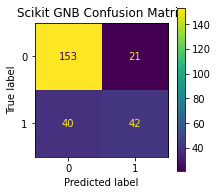

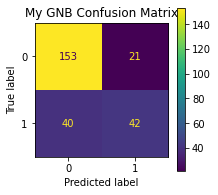

In [14]:
test_gaussian_on_dataset(X_train, y_train, X_test, y_test)

In [15]:
test_speed_on_dataset(X_train, y_train, X_test, y_test)

Scikit GNB fit performance: 0.0778741000000025s (100 times)
Scikit GNB predict performance: 0.017728800000000433s (100 times)
My GNB fit performance: 0.0305266999999958s (100 times)
My GNB predict performance: 0.7817897999999985s (100 times)


### Hotel Reviews dataset
Running and testing Gaussian Naive Bayes on the helpfulness of hotel reviews dataset.

In [16]:
reviews = pd.read_csv('HotelRevHelpfulness.csv', index_col=0)
print(reviews.shape)
reviews.head()

(486, 24)


,aveHelpfulnessRatioUser,stdevHelpfulnessRatioUser,pcReviewsExceedMinHelpfulnessSupport,numReviewsUser,numReviewsHotel,ratingUser,numberSubRatingsUser,subRatingMeanUser,subRatingStdevUser,aveRatingUser,...,completeness_2,completeness_3,numberTermsEntry,percentageAlphaCharsEntry,fractionUpperCaseCharsEntry,fractionYouVsIEntry,numberTermsSummaryQuote,percentageAlphaCharsSummaryQuote,fractionUpperCaseCharsSummaryQuote,reviewHelpfulness
hotelId,,,,,,,,,,,,,,,,,,,,,
17420,1.000000,0.000000,0.666667,3,16,5,4,4.000000,0.000000,4.333333,...,0,1,182,0.788474,0.025703,0.500000,6,0.815789,0.096774,1
1397,0.772487,0.377321,0.500000,12,233,5,0,0.000000,0.000000,4.333333,...,0,0,158,0.791888,0.012594,0.500000,1,1.000000,0.083333,1
1348,0.715473,0.300437,0.833333,12,302,4,7,3.714286,0.755929,4.166667,...,0,3,59,0.799639,0.024831,0.333333,4,0.828571,0.034483,0
5940,0.521250,0.481675,0.222222,36,6,1,4,1.000000,0.000000,3.527778,...,0,0,95,0.782212,0.029155,0.500000,2,0.800000,0.062500,0
38,0.603175,0.246926,1.000000,2,271,3,0,0.000000,0.000000,3.500000,...,0,0,43,0.805128,0.028662,0.000000,1,1.000000,0.142857,0


In [17]:
y = reviews.pop('reviewHelpfulness').values
x_raw = reviews.values
scaler = StandardScaler()
x = scaler.fit_transform(x_raw)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((324, 23), (324,), (162, 23), (162,))

Scikit GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.47      0.56      0.51        55
     Helpful       0.75      0.67      0.71       107

    accuracy                           0.64       162
   macro avg       0.61      0.62      0.61       162
weighted avg       0.65      0.64      0.64       162


CV x5 Scikit GNB: 
           test_score  fit_time  score_time
accuracy     0.652241  0.000793    0.000430
f1           0.728657  0.001182    0.001000
precision    0.720970  0.001006    0.001140
recall       0.737017  0.001000    0.001007

My GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.47      0.56      0.51        55
     Helpful       0.75      0.67      0.71       107

    accuracy                           0.64       162
   macro avg       0.61      0.62      0.61       162
weighted avg       0.65      0.64      0.64       162


CV x5 My GNB: 
           test_score  fit_time  score_time
accurac

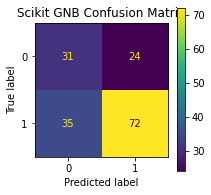

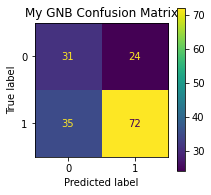

In [19]:
test_gaussian_on_dataset(x_train, y_train, x_test, y_test)

In [20]:
test_speed_on_dataset(x_train, y_train, x_test, y_test)

Scikit GNB fit performance: 0.08161759999999418s (100 times)
Scikit GNB predict performance: 0.018332399999998472s (100 times)
My GNB fit performance: 0.027136200000001054s (100 times)
My GNB predict performance: 0.5095144000000005s (100 times)


## Scikit vs My Gaussian Naives Bayes : Multiclass Classification
This function below will compare Scikit's Gaussian NB and mine in terms of performance.

In [21]:
def test_gaussian_on_multiclass_dataset(x_train, y_train, x_test, y_test):
    scorings = ['accuracy', 'f1_micro', 'precision_micro', 'recall_micro', 'f1_macro', 'precision_macro', 'recall_macro']
    X = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title("Scikit GNB Confusion Matrix")
    disp.plot(ax=ax)

    data = []
    for scoring in scorings:
        data.append({key: score.mean() for (key, score) in cross_validate(gnb, X, y, scoring=scoring).items()})
    print()
    print('CV x5 Scikit GNB: ')
    print(pd.DataFrame(data=data, columns=['test_score', 'fit_time', 'score_time'], index=scorings))
    print()
    
    mgnb = MyGaussianNB()
    mgnb.fit(x_train,y_train)
    y_pred = mgnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title("My GNB Confusion Matrix")
    disp.plot(ax=ax)
    
    results = []
    for scoring in scorings:
        results.append({key: score.mean() for (key, score) in cross_validate(mgnb, X, y, scoring=scoring).items()})
    print()
    print('CV x5 My GNB: ')
    print(pd.DataFrame(data=results, columns=['test_score', 'fit_time', 'score_time'], index=scorings))
    print()

### Vehicles dataset

In [22]:
vehicles = pd.read_csv('vehicle.csv', index_col=0)
print(vehicles.shape)
vehicles.head()

(846, 19)


,'CIRCULARITY','DISTANCE_CIRCULARITY','RADIUS_RATIO','PR.AXIS_ASPECT_RATIO','MAX.LENGTH ASPECT_RATIO','SCATTER_RATIO','ELONGATEDNESS','PR_AXIS_RECTANGULARITY','MAX_LENGTH_RECTANGULARITY','SCALED_VARIANCE_MAJOR','SCALED_VARIANCE_MINOR','SCALED_RADIUS_OF_GYRATION','SKEWNESS_ABOUT_MAJOR','SKEWNESS_ABOUT_MINOR','KURTOSIS_ABOUT_MAJOR','KURTOSIS_ABOUT_MINOR','HOLLOWS_RATIO','V.ELONGATEDNESS',TYPE
'COMPACTNESS',,,,,,,,,,,,,,,,,,,
95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,32,suv
91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,45,suv
104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,32,convertible
93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,46,suv
85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,45,minibus


In [23]:
y = vehicles.pop('TYPE').values
x_raw = vehicles.values
scaler = MinMaxScaler()

In [24]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(x_raw, y, test_size=1/4)

In [25]:
x_train = scaler.fit_transform(x_train_raw)
x_test = scaler.fit_transform(x_test_raw)


CV x5 Scikit GNB: 
                 test_score  fit_time  score_time
accuracy           0.443244  0.001798    0.000607
f1_micro           0.443244  0.001799    0.002315
precision_micro    0.443244  0.001398    0.002010
recall_micro       0.443244  0.002194    0.001402
f1_macro           0.410793  0.002803    0.002712
precision_macro    0.499568  0.002148    0.002198
recall_macro       0.452073  0.001976    0.001896


CV x5 My GNB: 
                 test_score  fit_time  score_time
accuracy           0.443244  0.001018    0.012469
f1_micro           0.443244  0.001005    0.012581
precision_micro    0.443244  0.000997    0.011611
recall_micro       0.443244  0.001001    0.013696
f1_macro           0.410793  0.001218    0.011204
precision_macro    0.499568  0.001210    0.014223
recall_macro       0.452073  0.001001    0.012565



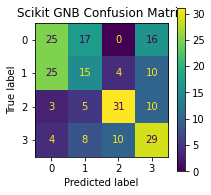

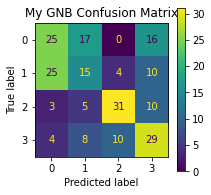

In [26]:
test_gaussian_on_multiclass_dataset(x_train, y_train, x_test, y_test)

In [27]:
test_speed_on_dataset(x_train, y_train, x_test, y_test)

Scikit GNB fit performance: 0.14984149999999374s (100 times)
Scikit GNB predict performance: 0.027230100000004143s (100 times)
My GNB fit performance: 0.07968629999999877s (100 times)
My GNB predict performance: 1.366615099999997s (100 times)


# Conclusion


- Evaluation: 

  - their confusion matrices are equals ;
  - their accuracies, f1 scores, recall and precisions are equals ;

- Speed:

  - `fit` method: Scikit is slower than mine (about 4 times) ;
  - `predict` method: Scikit is faster than mine (about 30 times).

- What I suspect for these differences:

  - Scikit may compute other values when fitting the model in order to optimize the predictions ;
  - Scikit may use a better but equivalent algorithm to compute the conditional probabilities.